# Sleep Health and Lifestyle Analysis

Este notebook tiene como objetivos:
1. **Identificación de Arquetipos**: Clustering no supervisado usando K-Means.
2. **Predicción de Enfermedades**: Clasificación supervisada usando KNN para predecir 'Sleep Disorder'.

## 1. Carga y Limpieza de Datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Configuración de gráficos
sns.set(style="whitegrid")

# Cargar el dataset
df = pd.read_csv('datasets/Sleep_health_and_lifestyle_dataset.csv')
df.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [2]:
# Rellena los valores nulos en 'Sleep Disorder' con 'None'
df['Sleep Disorder'] = df['Sleep Disorder'].fillna('None')

# Normaliza 'BMI Category'
df['BMI Category'] = df['BMI Category'].replace('Normal Weight', 'Normal')

# Separar 'Blood Pressure' en 'BP_Systolic' y 'BP_Diastolic'
df[['BP_Systolic', 'BP_Diastolic']] = df['Blood Pressure'].str.split('/', expand=True).astype(int)
df = df.drop(columns=['Blood Pressure'])

# Eliminar 'Person ID'
df = df.drop(columns=['Person ID'])

# Verificar info del dataframe limpio
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Gender                   374 non-null    object 
 1   Age                      374 non-null    int64  
 2   Occupation               374 non-null    object 
 3   Sleep Duration           374 non-null    float64
 4   Quality of Sleep         374 non-null    int64  
 5   Physical Activity Level  374 non-null    int64  
 6   Stress Level             374 non-null    int64  
 7   BMI Category             374 non-null    object 
 8   Heart Rate               374 non-null    int64  
 9   Daily Steps              374 non-null    int64  
 10  Sleep Disorder           374 non-null    object 
 11  BP_Systolic              374 non-null    int64  
 12  BP_Diastolic             374 non-null    int64  
dtypes: float64(1), int64(8), object(4)
memory usage: 38.1+ KB


## 2. Preprocesamiento de Datos
Para algoritmos basados en distancia como K-Means y KNN, es crítico escalar las variables numéricas y codificar las categóricas.

In [3]:
# Definir columnas
numeric_cols = ['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 
                'Stress Level', 'Heart Rate', 'Daily Steps', 'BP_Systolic', 'BP_Diastolic']
categorical_cols = ['Gender', 'Occupation', 'BMI Category']

# Escalar numéricas
scaler = StandardScaler()
X_num = pd.DataFrame(scaler.fit_transform(df[numeric_cols]), columns=numeric_cols)

# OneHotEncoding para categóricas
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_cat = pd.DataFrame(encoder.fit_transform(df[categorical_cols]), 
                     columns=encoder.get_feature_names_out(categorical_cols))

# Combinar en X_processed
X_processed = pd.concat([X_num, X_cat], axis=1)

print("Shape de X_processed:", X_processed.shape)
X_processed.head()

Shape de X_processed: (374, 22)


,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps,BP_Systolic,BP_Diastolic,Gender_Male,...,Occupation_Lawyer,Occupation_Manager,Occupation_Nurse,Occupation_Sales Representative,Occupation_Salesperson,Occupation_Scientist,Occupation_Software Engineer,Occupation_Teacher,BMI Category_Obese,BMI Category_Overweight
0,-1.753096,-1.298887,-1.098280,-0.825418,0.347021,1.654719,-1.619584,-0.330002,-0.268102,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,-1.637643,-1.173036,-1.098280,0.039844,1.475592,1.170474,1.970077,-0.459239,-0.755640,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.637643,-1.173036,-1.098280,0.039844,1.475592,1.170474,1.970077,-0.459239,-0.755640,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.637643,-1.550588,-2.771424,-1.402260,1.475592,3.591698,-2.362273,1.479309,0.869486,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-1.637643,-1.550588,-2.771424,-1.402260,1.475592,3.591698,-2.362273,1.479309,0.869486,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


## 3. Análisis de Arquetipos (clustering K-Means)
Usaremos el método del codo para encontrar un k óptimo y luego interpretaremos los clusters.

/opt/anaconda3/envs/sis_pred/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/sis_pred/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/sis_pred/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/sis_pred/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/sis_pred/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/sis_pred/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/sis_pred/lib/python3.10/site-packages/sklearn/utils/extmath.py:2

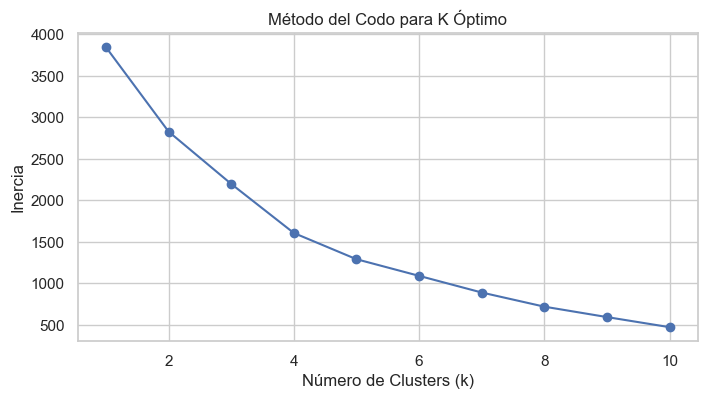

In [4]:
# Método del codo
inertias = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_processed)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K_range, inertias, 'bo-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo para K Óptimo')
plt.show()

In [5]:
# Entrenar con k=3 (Ejemplo razonable según el problema)
kmeans_final = KMeans(n_clusters=3, random_state=42, n_init=10)
df['Archetype'] = kmeans_final.fit_predict(X_processed)

# Tabla resumen para interpretación
archetype_profile = df.groupby('Archetype')[numeric_cols].mean().round(2)
print("Perfil Promedio por Arquetipo:")
display(archetype_profile)

# Conteo de personas por arquetipo
print("\nDistribución de Arquetipos:")
print(df['Archetype'].value_counts())

Perfil Promedio por Arquetipo:


/opt/anaconda3/envs/sis_pred/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/sis_pred/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/sis_pred/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps,BP_Systolic,BP_Diastolic
Archetype,,,,,,,,,
0,39.26,6.41,6.22,41.22,6.53,71.97,5611.63,129.86,85.00
1,53.81,7.13,7.57,82.46,5.42,72.00,8274.63,139.97,94.88
2,39.93,7.66,8.01,63.41,4.54,68.17,7141.57,123.31,80.54



Distribución de Arquetipos:
Archetype
2    178
0    129
1     67
Name: count, dtype: int64


### Visualización de Clusters (PCA)

/opt/anaconda3/envs/sis_pred/lib/python3.10/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/opt/anaconda3/envs/sis_pred/lib/python3.10/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/opt/anaconda3/envs/sis_pred/lib/python3.10/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T


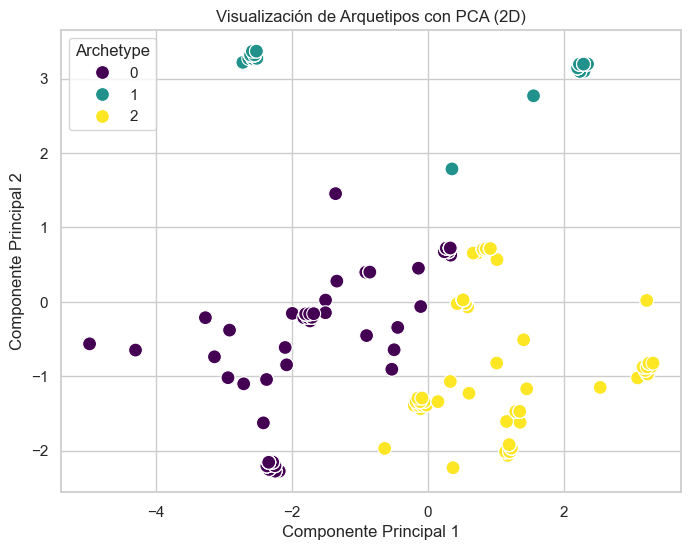

In [6]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['Archetype'], palette='viridis', s=100)
plt.title('Visualización de Arquetipos con PCA (2D)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

## 4. Clasificación de Enfermedades (KNN)
Predeciremos la columna 'Sleep Disorder' ('None', 'Sleep Apnea', 'Insomnia').

Reporte de Clasificación:
              precision    recall  f1-score   support

    Insomnia       0.72      0.81      0.76        16
        None       0.95      0.98      0.97        43
 Sleep Apnea       0.85      0.69      0.76        16

    accuracy                           0.88        75
   macro avg       0.84      0.83      0.83        75
weighted avg       0.88      0.88      0.88        75



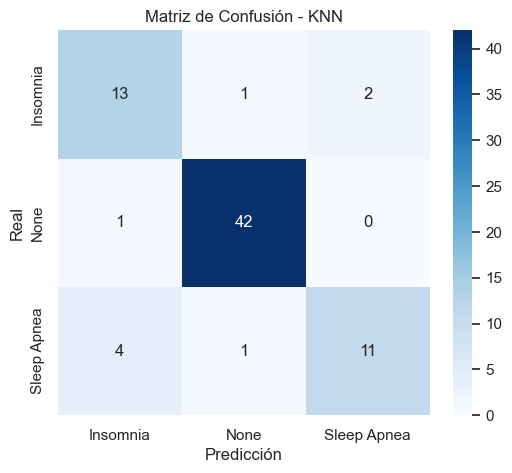

In [7]:
# Definir X e y
X = X_processed
y = df['Sleep Disorder']

# Split Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Predicciones
y_pred = knn.predict(X_test)

# Evaluación
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred))

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=knn.classes_, yticklabels=knn.classes_)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - KNN')
plt.show()